# Battery manufacturing costs example


The following notebook provides an example of the battery cost model. 

In [1]:
#Import required packages
import numpy as np
import pandas as pd
import brightway2 as bw
import sys
import matplotlib.pyplot as plt

#Import the battery design module from a local path
local_path =r"C:\Users\Joris\OneDrive - Newcastle University\Python\Projects\Batt_Sust_Model-1\batt_sust_model" #ADD PATH
sys.path.insert(1, local_path)
from battery_design import battery_design as bd
import battery_cost as bat_cost
import battery_emissions as bat_lca

#Local path to BatPaC version 5
path_batpac = r"C:\Users\Joris\OneDrive - Newcastle University\PhD\Models\battery_sustainability_model\Case study\BatPaC 5.0 - 8March2022.xlsm"#ADD PATH



## Calculate battery design
First, the material content of a single battery is obtained. The battery design parameters of a Volkswagen ID.4 are used. See also the [battery design example notebook](https://github.com/jbaars2/Batt_Sust_Model/blob/main/example%20notebooks/Battery%20design/Example%20notebook%battery%design.ipynb) for more information

In [157]:
#Establish battery system class of specific design:
battery = bd.Battery_system (    
                             vehicle_type='EV', 
                             electrode_pair='NMC622-G (Energy)',                              
                             cells_per_module=24, 
                             modules_per_row=6,
                             rows_of_modules=2, 
                             sep_film_thickness = 17,
                             negative_foil_thickness = 12,
                             positive_foil_thickness = 14,
                             positive_electrode_thickness = 87.3,
                             cells_in_parallel=3, #https://static.nhtsa.gov/odi/tsbs/2021/MC-10186407-0001.pdf
                             modules_in_parallel = 1,  
                             silicon_anode= 0.00, 
                             calculate_fast_charge = 'Yes',
                             max_charging_time = 33,  
                             max_charge_power = 135, 
                             available_energy=94,
                             A_coefficient=135.9999272, #based on EPA data
                             B_coefficient= 3.732390689,#based on EPA data
                             C_coefficient=0.406771986,#based on EPA data
                             vehicle_range_miles =410*0.6214, #EV-database using the 'EVDB Real Range' (converted to miles) https://ev-database.org/car/1273/Volkswagen-ID4-1st
                             motor_power = 150 #Based on adac.de VW ID.4 Pro Performance https://www.adac.de/rund-ums-fahrzeug/auto       
                             )
#Establish parameter dictionary
parameter_dict = battery.parameter_dictionary()

In [158]:
# #Solve battery design in BatPaC returning nested dictionary with material contents and parameter values
# #Make sure BatPaC is not open or running in the background
bp_output = bd.solve_batpac_battery_system (batpac_path = path_batpac, parameter_dict=parameter_dict, visible=True)

## Calculate the factor requirement matrix ($\mathbf{F}$)

The factor requirements included are land/building area, capital equipment and labour.

The factor requirement matrix ($\mathbf{F}$) represents the factors (rows) and battery production processes (columns). 

Factor requirement ($F$) for all battery production process are based on the calculations of BatPaC as described in the BatPaC manual. Here factor requirements are adjusted to account for varying production volumes with the following equation:
$$F= F_b \left(\frac{P}{P_b}\right)^p$$

where $F_b$ refers to the baseline factor requirement matrix, $P$ to the modelled annual production process rate, $P_b$ to the base line process rate and $p$ is the scale factor. $F_b$, $P_b$ and $p$ are obtained from BatPaC.


The BatPaC calculations are used and converted to a Python model

In [4]:
#Convert BatPaC output to Brightway project parameter names 
result_dict = bat_lca.output_as_bw_param(bp_output)

# Append additional project parameters and recalculate project parameters (e.g. total anode active material based on process yield)
result_dict = {**bat_lca.get_project_parameters_dict(bp_output), **result_dict}
#Append battery design parameters:
result_dict.update(bp_output['general_battery_parameters'])

The factors_battery_production function returns the annual physical factor requirement matrix for land (m2) and labour (hr) and monetary value for capital requirement for a desired production capacity

In [119]:
#Define annual manufacturing capacity (packs per year)
result_dict['battery_manufacturing_capacity'] = 500000

#Returns the aggregated matrix whereby the processes match the LCA processes:
F = bat_cost.factors_battery_production(result_dict, return_aggregated=True)

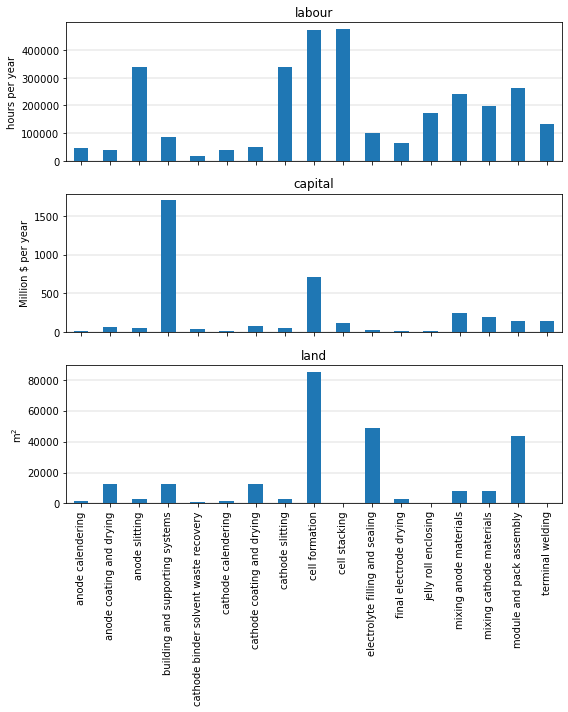

In [120]:
fig, ax = plt.subplots(3,1, sharex=True, figsize=(8,10))
for i, row in enumerate(F.index):
    F.loc[row].plot.bar(ax=ax[i], zorder=2)
    ax[i].set_title(row)
    ax[i].grid(lw=0.4, axis='y', zorder=0)
ax[0].set_ylabel('hours per year')
ax[1].set_ylabel('Million $ per year')
ax[2].set_ylabel(r'm$^2$')
fig.tight_layout()

The monetary $\bf{F}$ matrix ($\bf{F}_m$) can be obtained by multiplying $\bf{F}$ with the factor cost ($\mathbf{\pi}$). 

The operating expenses (e.g. R&D investments and depreciation rates) are allocated to the factor cost based on the multipliers for overhead to basic costs as used in BatPaC.




In [121]:
#Default BatPaC values (labour ($/hr), capital ($) land ($/m2)):
factor_cost          = pd.Series([25, 1000000, 3000], index=['labour', 'capital', 'land'])
factor_cost_multiplier = pd.Series(bat_cost.factor_overhead_multiplier())
#Monetary factor requirement matrix:
F_m = ((factor_cost*factor_cost_multiplier)*F.T).T


Using the same factor prices as in BatPaC, the total labour, capital and land cost are identical to the values in BatPaC, sheet 'Cost Breakdown', cell K71, K82, K93

In [122]:
F_m.sum(axis=1)/500000

labour      287.583151
capital    1845.062664
land        224.227973
dtype: float64

## Calculate material cost matrix ($\mathbf{C}$)

The material cost matrix is based on the computational structure for life cycle cost (see also [Moreau and Weidema, 2015](https://link.springer.com/article/10.1007/s11367-015-0952-1) and [Heijungs et al., 2013](https://link.springer.com/article/10.1007/s11367-012-0461-4)).


The material cost matrix, the monetary equivalent of the technology matrix ($\mathbf{A}$), is obtained by multiplying the technology matrix with the material price vector ($\mathbf{\alpha}$) 

We first obtain the cut-off foreground matrix as a Dataframe as established in the Brightway (see also LCA example notebook).

In [108]:
#Brightway2 general setup:
bw.projects.set_current('parameterised_battery_lca')
bw.bw2setup()
#Import ecoinvent 3.7.1:
if 'eidb 3.7' in bw.databases:
    pass
else:
    pathi37 = 'path to ecoinvent'
    eidb37 = bw.SingleOutputEcospold2Importer(pathi37, 'eidb 3.7')
    eidb37.apply_strategies()
    eidb37.statistics()


Biosphere database already present!!! No setup is needed


In [109]:
# First the Brightway project parameters are updated
bat_lca.update_param_battery_bw(result_dict)


# # Cut off the exchanges if activity if present in the 'cut off database'. E.g. 6um copper foil production is present in the 'cut of database' and will be cut in the anode coating process. All cut-off exchanges are set to zero
a = bat_lca.modules_with_cuts('cut_off')

In [110]:


# Divide all battery production activities by total battery system weight:
bat_product_act = [act['name'] for act in bw.Database('battery_production')]
for act in bat_product_act:
    pack_weight = result_dict['battery_pack']
    a[act]['amount'] = a[act]['amount']/pack_weight
    for exc in a[act]['cuts'].keys():
        a[act]['cuts'][exc][1] = a[act]['cuts'][exc][1]/pack_weight
        
# #Cut modules:
# bat_lca.cut_modules_to_zero(a)

# Establish product-module dataframe of base system
A=bat_lca.modular_technology_matrix(a)

A

,anode electrode scrap handling,anode binder (CMC) production,"market for aluminium, wrought alloy",battery management system production,cathode active material (LFP) import,final electrode drying,battery jacket aluminium,market for manganese dioxide,anode slitting,electrolyte (LMO) production,...,cathode current collector Al (13um) production,battery jacket steel,cathode binder solvent waste handling,cell scrap handling,anode binder additive (SBR) production,module container production,cell formation,"market for wastewater, average",anode current collector Cu (6um) production,cathode current collector Al (18um) production
anode electrode scrap,-1,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0,...,0.0,0,0,0,0.0,0.0,0.0000,0,0.0,0.0
anode binder (CMC),0,1,0.0,0.0,0.0,0.0,0,0.0,0.0,0,...,0.0,0,0,0,0.0,0.0,0.0000,0,0.0,0.0
"aluminium, wrought alloy",0,0,1.0,0.0,0.0,0.0,-1,0.0,0.0,0,...,-1.0,0,0,0,0.0,0.0,0.0000,0,0.0,-1.0
battery management system,0,0,0.0,1.0,0.0,0.0,0,0.0,0.0,0,...,0.0,0,0,0,0.0,0.0,0.0000,0,0.0,0.0
cathode active material (LFP),0,0,0.0,0.0,1.0,0.0,0,0.0,0.0,0,...,0.0,0,0,0,0.0,0.0,0.0000,0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
module container,0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0,...,0.0,0,0,0,0.0,1.0,0.0000,0,0.0,0.0
cell,0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0,...,0.0,0,0,0,0.0,0.0,0.5974,0,0.0,0.0
"wastewater, average",0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0,...,0.0,0,0,0,0.0,0.0,0.0000,-1,0.0,0.0
anode current collector Cu (6um),0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0,...,0.0,0,0,0,0.0,0.0,0.0000,0,1.0,0.0


The technology matrix can now be multiplied by the material price vector. <br>


We utilise the same calculations as in BatPaC to obtain the material cost and therefore include both prices per kg as well as the plus per unit. 

Some items are only based on a unit price (e.g. pack heating system) and others include both a mass price and unit price (e.g. row racks or the pack jacket) 

In [244]:
#import BatPaC material prices:
df_pr_mass = pd.read_csv('data/material_price_mass_batpac.csv').set_index('Goods')
df_pr_unit = pd.read_csv('data/material_price_unit_batpac.csv').set_index(['Good', 'Parameter'])
df_pr_unit = df_pr_unit['Value'].unstack().fillna(0)
dict_pr_unit = {}
for k, v in df_pr_unit.T.to_dict().items():
    dict_pr_unit[k] = {}
    for k2, v2 in v.items():
        if v2 != 0:
            dict_pr_unit[k][k2] = v2

In [246]:
import importlib
importlib.reload(bat_cost)

C = bat_cost.material_cost_matrix (A, df_pr_mass['Value'], dict_pr_unit,  result_dict )


next we establish the scaling vector $\mathbf{s}$ using the matrix based LCI model:  

In [247]:
#Inverse the A' matrix:
A_inv = pd.DataFrame(np.linalg.pinv(A.values), A.columns, A.index)

#Establish final product demand vector for 1 battery based on pack weight
y = pd.Series(data = 0, index=A.index)
y.loc['battery pack'] = pack_weight 

#Calculate scaling vector:
s = A_inv.dot(y)

C_scaled = C*s

Now the total battery cost can be calculated:

In [248]:
F_m_pack = pd.DataFrame(columns = C.columns, index=F.index).fillna(0)
F_m_pack[F_m.columns] = (F_m/500000)

print ('Total battery material costs are: $' , round(C.dot(s).sum(), 2))
print ('Total battery factor costs are: $' , round(F_m_pack.sum(axis=1).sum(), 2))

print ('Total pack level cost: $',round(round(F_m_pack.sum(axis=1).sum(), 2)+ round(C.dot(s).sum(), 2),2))
print ('Total kWh level cost: $', round( (F_m_pack.sum(axis=1).sum() + C.dot(s).sum())/result_dict['pack_energy_kWh'], 2), 'kWh')

Total battery material costs are: $ 7872.45
Total battery factor costs are: $ 2356.87
Total pack level cost: $ 10229.32
Total kWh level cost: $ 116.35 kWh


As you can see, the kWh cost are almost identical to BatPaC. The minor difference can be explained by minor differences in terms of process yields included/excluded for cell container, cell terminals, cathode solvent and rounding of process yields

C:\Users\Joris\AppData\Local\Temp\ipykernel_3912\2884085348.py:15: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_cost_results = pd.DataFrame((C_scaled/bat_cost.material_overhead_multiplier()).sum(axis=1).append(F_m.sum(axis=1)/500000).sort_values().tail(10), columns=['Modelled'])


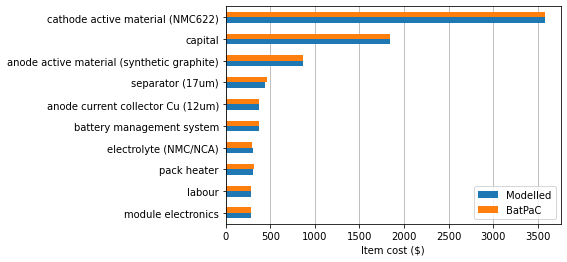

In [115]:
batpac_cost = {
    'cathode active material (NMC622)': 3578,
    'capital' :1844,
    "anode active material (synthetic graphite)": 864,
    "separator (17um)": 460,
    "anode current collector Cu (12um)": 371, 
    "battery management system":368,
    "electrolyte (NMC/NCA)": 294,
    "pack heater": 315,
    "module electronics": 282,
    "labour" : 288    
    
}

df_cost_results = pd.DataFrame((C_scaled/bat_cost.material_overhead_multiplier()).sum(axis=1).append(F_m.sum(axis=1)/500000).sort_values().tail(10), columns=['Modelled'])
df_batpac = pd.DataFrame.from_dict( batpac_cost, orient='index').rename(columns={0:'BatPaC'})
df_cost_results.join(df_batpac).plot.barh(zorder=2)

plt.xlabel('Item cost ($)')
plt.grid(axis='x',zorder=0)

### Impact of production scale

The annual production outputs (packs per year) can be changed, adjusting the total cost accordingly based on the exponential method as used in BatPaC

Text(0.5, 1.0, 'Factor cost per battery pack by battery production capacity')

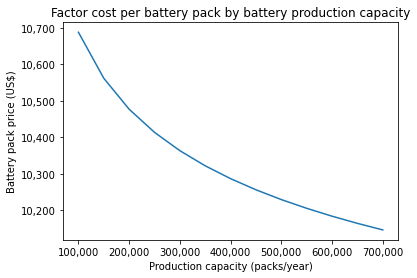

In [116]:
production = list(range(100000, 750000, 50000))
land = []
labour = []
capital = []
material = []

for x in production:
    result_dict['battery_manufacturing_capacity'] = x
    F = bat_cost.factors_battery_production(result_dict, return_aggregated=True)
    factor_cost_overhead = list(bat_cost.factor_overhead_multiplier().values())    
    a = (F.T*(factor_cost*factor_cost_overhead))
    f = a.sum()/x
    labour.append(f[0])
    capital.append(f[1])
    land.append(f[2])
    C = bat_cost.material_cost_matrix (A, df_pr_mass['Value'], dict_pr_unit,  result_dict)
    C_scaled = C*s
    material.append(C_scaled.values.sum())
    
#reset production capacity
result_dict['battery_manufacturing_capacity'] = 500000

#Plot results
from matplotlib.ticker import StrMethodFormatter
a = [land, labour, capital, material]
factor_cost_all = sum(map(np.array, a))
fig, ax = plt.subplots()
ax.plot(production, factor_cost_all,label='Factor costs')
plt.ylabel('Battery pack price (US$)')

plt.xlabel('Production capacity (packs/year)')
ax.xaxis.set_major_formatter(StrMethodFormatter('{x:,g}'))
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,g}'))
plt.title('Factor cost per battery pack by battery production capacity')

### Impact of production location:

Labour, land/building and energy prices can be changed to represent a specific country:

In [249]:
df_factor_price = pd.read_csv("data/factor_prices_europe.csv", index_col=0).dropna()
df_factor_price

,FR,DE,HU,NO,PL,SE,GB,European average
labour,43.25,42.18,11.73,59.48,12.68,43.25,33.77,35.19
capital,1000000.00,1000000.00,1000000.00,1000000.00,1000000.00,1000000.00,1000000.00,1000000.00
land,2380.08,2213.95,1219.94,3683.20,1503.39,3074.60,2291.40,2338.08


Energy costs in BatPaC are embedded in the cost of land and building. 

As we have included the foreground energy consumption, we can calculate the cost of these flows with the prices of regional electricity and natural gas:

In [250]:
df_energy_price  = pd.read_csv("data/regional_energy_price.csv", index_col=0).dropna()
df_energy_price

,FR,DE,HU,NO,PL,SE,GB,European average
"electricity for battery production, medium voltage",0.113,0.181,0.110,0.091,0.104,0.084,0.176,0.122
"heat, district or industrial, natural gas for battery production",0.012,0.010,0.009,0.010,0.011,0.012,0.009,0.010


In [101]:
df_cost_total

,FR,DE,HU,NO,PL,SE,GB,BatPac
labour,497.518851,485.210292,134.934014,684.217832,145.862174,497.518851,388.467320,404.802043
capital,1845.062664,1845.062664,1845.062664,1845.062664,1845.062664,1845.062664,1845.062664,1845.062664
land,177.893505,165.476507,91.181558,275.292156,112.367364,229.803775,171.265326,174.754313
material,7872.441271,7872.441271,7872.441271,7872.441271,7872.441271,7872.441271,7872.441271,NaN
energy,192.243767,280.222596,179.082917,155.826230,176.799362,152.160494,270.306918,NaN


Text(0.5, 0, 'Battery production location')

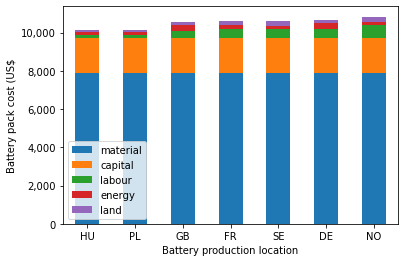

In [124]:
df_cost_total = pd.DataFrame (index = ['labour', 'capital', 'land', 'material', 'energy',], columns = df_factor_price.columns)

gas = 'heat, district or industrial, natural gas for battery production'
electr = 'electricity for battery production, medium voltage'

for country, factor_cost in df_factor_price.iteritems():
    # add the energy prices to the material price database
    df_pr_mass.loc [electr, 'Value'] = df_energy_price.loc['electricity for battery production, medium voltage', country]
    df_pr_mass.loc [gas, 'Value'] = df_energy_price.loc['heat, district or industrial, natural gas for battery production', country]
    F = bat_cost.factors_battery_production(result_dict, return_aggregated=True)
    factor_cost_overhead = list(bat_cost.factor_overhead_multiplier().values())    
    a = (F.T*(factor_cost*factor_cost_overhead))
    df_cost_total[country] =a.sum()/500000
    C = bat_cost.material_cost_matrix (A, df_pr_mass['Value'], dict_pr_unit,  result_dict)
    
    df_cost_total.loc['energy', country] = (C*s).sum(axis=1).loc[[gas, electr]] .sum()
    df_cost_total.loc['material', country] = (C*s).values.sum() - df_cost_total.loc['energy', country] 
df_cost_total.drop('European average', axis=1, inplace=True)



index_structure= df_cost_total.sum()

fig, ax = plt.subplots()

df_cost_total.sort_values(by='FR', ascending=False)[index_structure.sort_values(ascending=True).index[:]].T.plot.bar(stacked=True, rot=0, ax=ax)
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,g}'))
plt.ylabel('Battery pack cost (US$')
plt.xlabel('Battery production location')

### Impact of metal prices on CAM costs

To calculate the impact of fluctuating metal prices on the cathode active material (CAM) cost, we use the production cost and profit margin (PCPM) estimation of the CAM. 


In this example, we use a PCPM for NMC622 of 6.11 $/kg based on [Greenwood et al., 2020](https://www.sciencedirect.com/science/article/pii/S266624852100010X) and iterate over the cobalt, nickel, manganese and lithium prices of the last 20 years.




In [234]:
#import the metal content of the CAM
df_element_weight = pd.read_csv("data/elemental_weight_cam.csv").set_index(['Component','Element'])
df_element_weight = df_element_weight['Value'].unstack().fillna(0)
# import the historic metal prices:
df_metal_prices = pd.read_csv("data/historic_metal_price.csv", index_col=0)


In [24]:
# Iterate through the historic metal price data sets and multiply this by the metal content in the CAM:

historic_NMC = pd.DataFrame(index=df_metal_prices.index, columns = ['NMC622 price'])
dates = []
for date, value in df_metal_prices.iterrows():
    historic_NMC.loc[date, 'NMC622 price'] =bat_cost.cam_price(value, df_element_weight,pcpm_cam={'cathode active material (NMC622)':6.11})['cathode active material (NMC622)']
    dates.append(date)
 

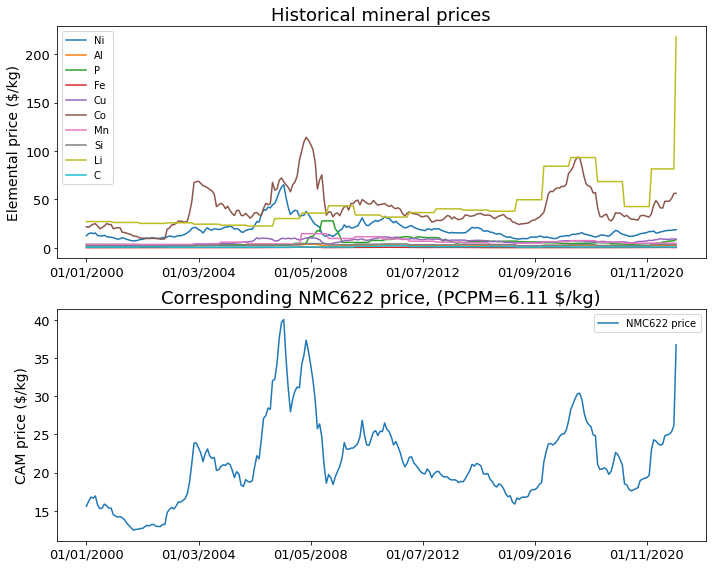

In [25]:
fig, ax = fig, ax = plt.subplots(2,1, figsize=(10,8))

df_metal_prices.plot( ax=ax[0], fontsize=13)
historic_NMC.plot(ax=ax[1], fontsize=13)

ax[0].set_ylabel('Elemental price ($/kg)', fontsize=14)
ax[1].set_ylabel('CAM price ($/kg)', fontsize=14)
ax[0].set_xlabel('')
ax[1].set_xlabel('')
ax[0].set_title('Historical mineral prices', fontsize=18)
ax[1].set_title('Corresponding NMC622 price, (PCPM=6.11 $/kg)', fontsize=18)
ax[1].legend()
fig.tight_layout()

Now we can calculate the corresponding battery cost by replacing the NMC622 price in the material cost price dataframe

In [26]:
historic_pack_cost = pd.DataFrame(index=df_metal_prices.index, columns = ['Pack cost'])

for date, price in historic_NMC.iterrows():
    #replace the NMC622 price
    df_pr_mass.loc['cathode active material (NMC622)', 'Value'] = price.values[0]
    C = bat_cost.material_cost_matrix (A, df_pr_mass['Value'], dict_pr_unit,  result_dict, overhead_multiplier=None)
    C_scaled = C.dot(s)
    historic_pack_cost.loc[date, 'Pack cost'] = C_scaled.values.sum()+F_m.values.sum()/500000    

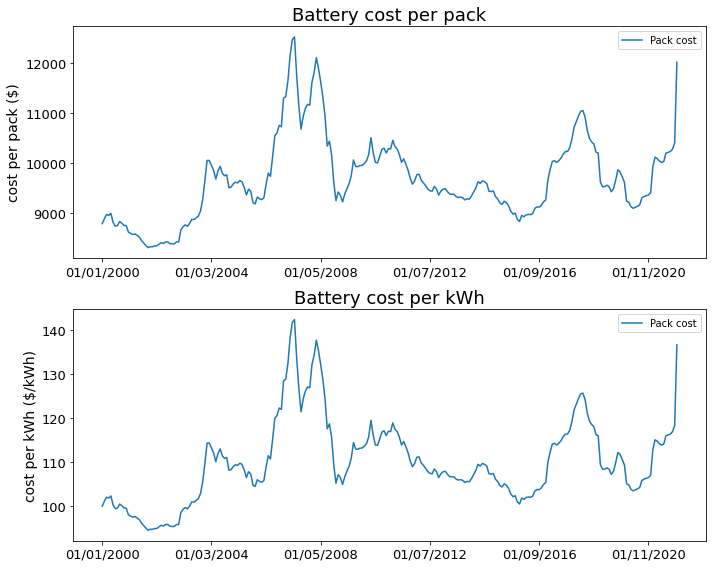

In [27]:
fig, ax = fig, ax = plt.subplots(2,1, figsize=(10,8))

historic_pack_cost.plot( ax=ax[0], fontsize=13)
(historic_pack_cost/result_dict['pack_energy_kWh']).plot(ax=ax[1], fontsize=13)
ax[0].set_ylabel('cost per pack ($)', fontsize=14)
ax[1].set_ylabel('cost per kWh ($/kWh)', fontsize=14)
ax[0].set_xlabel('')
ax[1].set_xlabel('')
ax[0].set_title('Battery cost per pack', fontsize=18)
ax[1].set_title('Battery cost per kWh', fontsize=18)
fig.tight_layout()

### Impact of different cathode chemistries

We change the cathode chemistry in BatPaC by iterating over different default chemistries, including LFP, LMO, NMC333, NMC532, NMC622 and NMC811

In [125]:

cathode_chemistry         = ['LFP-G (Energy)','LMO-G (Energy)','NMC333-G (Energy)', 'NMC532-G (Energy)', 'NMC622-G (Energy)', 'NMC811-G (Energy)']

dict_design = {}

for param in cathode_chemistry:
    battery = bd.Battery_system (
                             vehicle_type='EV', 
                             cells_per_module=24, 
                             modules_per_row=6,
                             rows_of_modules=2, 
                             sep_film_thickness = 17,
                             negative_foil_thickness = 12,
                             positive_foil_thickness = 14,
                             positive_electrode_thickness = 87.3,
                             cells_in_parallel=3, #https://static.nhtsa.gov/odi/tsbs/2021/MC-10186407-0001.pdf
                             modules_in_parallel = 1,  
                             silicon_anode= 0.00, 
                             calculate_fast_charge = 'Yes',
                             max_charging_time = 33,  
                             max_charge_power = 135, 
                             available_energy=94,
                             A_coefficient=135.9999272, #based on EPA data
                             B_coefficient= 3.732390689,#based on EPA data
                             C_coefficient=0.406771986,#based on EPA data
                             vehicle_range_miles =410*0.6214, #EV-database using the 'EVDB Real Range' (converted to miles) https://ev-database.org/car/1273/Volkswagen-ID4-1st
                             motor_power = 150, #Based on adac.de VW ID.4 Pro Performance https://www.adac.de/rund-ums-fahrzeug/auto               
                             electrode_pair=param, 

                                 )
    parameter_dict = battery.parameter_dictionary()

    #Save each BatPaC output in design dictionary:
    dict_design[param] = parameter_dict
    

In [126]:
#Solve in BatPaC. Make sure BatPaC is closed!
result_dict_all = bd.solve_batpac_battery_system_multiple (
    batpac_path = path_batpac,
    parameter_dict_all=dict_design, 
    save=False,
    visible=False)

100%|██████████| 6/6 [00:31<00:00,  5.20s/it]


Establish the foreground matrix for each battery design

In [127]:
# Empty np array of size all pack design * materials * processes
A_matrix_nested = np.zeros((len(result_dict_all), len(A.index), len(A.columns)))


# dictionary of the battery design parameters for all designs in non-alphanumeric parameters
param_dict_all = {}

# Default process parameters:
project_param = bat_lca.get_project_parameters_dict(bp_output)

# iterate over all pack designs and solve the process formulas based on specific pack parameters and process formulas:
for idx, k in enumerate(result_dict_all.keys()):
    mc = result_dict_all[k]["material_content_pack"]
    par = result_dict_all[k]["general_battery_parameters"]
    param_dict_all[k] = {**project_param, **bat_lca.output_as_bw_param(result_dict_all[k]), **par}
    A_matrix_temp = bat_lca.calculate_modular_A(A, param_dict_all[k])
    A_matrix_nested[idx] = A_matrix_temp


Calculate the factor requirements and corresponding cost

In [142]:
factor_cost = pd.Series([25, 1000000, 3000], index=["labour", "capital", "land"])

F_physical_nested = bat_cost.factors_battery_production(param_dict_all, run_multiple=True)

# Using np.einsum to establish the monetary F matrix:
F_monetary_nested = np.einsum("ijk, j -> ijk", F_physical_nested, (factor_cost * factor_cost_overhead).values)


100%|██████████| 6/6 [00:00<00:00, 101.47it/s]


Calculate the material cost matrix

In [241]:
df_pr_mass = pd.read_csv("data/material_price_mass_batpac.csv").set_index("Goods")

# non scaled
C_matrix_nested = bat_cost.material_cost_matrix(
    A_matrix_nested,
    df_pr_mass["Value"],
    dict_pr_unit,
    system_design_parameters=param_dict_all,
    process_columns=A.columns.to_list(),
    material_rows=A.index.to_list(),
    run_multiple=True,
)

# Scaled:
s_nested = np.zeros([C_matrix_nested.shape[0], C_matrix_nested.shape[1]])

for idx, design in enumerate(param_dict_all.keys()):
    A_inv = pd.DataFrame(np.linalg.pinv(A_matrix_nested[idx]), A.columns, A.index)
    y = pd.Series(data=0, index=A.index)
    y.loc["battery pack"] = pack_weight
    s_nested[idx] = A_inv.dot(y)

C_nested_scaled = np.einsum("ijk, ij -> ijk", C_matrix_nested, s_nested)


100%|██████████| 6/6 [00:00<00:00, 10.60it/s]


As you can see, LMO and LFP are the cheapest choices but increase the battery weight and volume significantly due to the lower energy dense materials

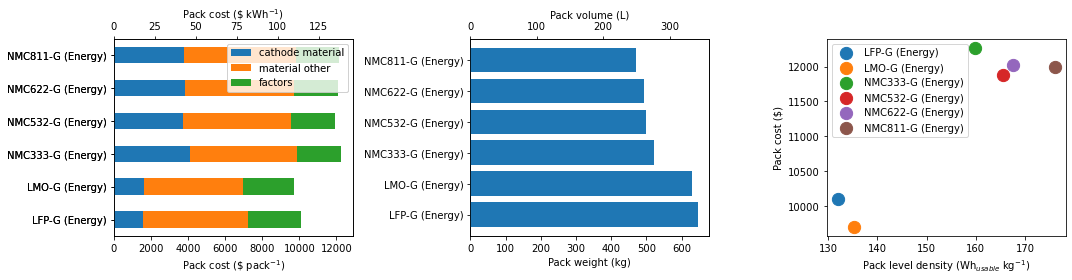

In [229]:
fig, ax = plt.subplots(1,3, figsize=(15,4))

df_cost_chemistries = pd.DataFrame(columns = param_dict_all.keys(), index=['cathode material', 'material other', 'factors'] )
cath_materials = [A.index.get_loc(x) for x in A.index if 'cathode active material' in x]

for idx, chem in enumerate(param_dict_all.keys()):
    df_cost_chemistries.loc['cathode material', chem] = C_nested_scaled[idx, :,cath_materials].sum()
    df_cost_chemistries.loc['material other', chem] = C_nested_scaled[idx].sum()-C_nested_scaled[idx, :,cath_materials].sum()
    df_cost_chemistries.loc['factors', chem] = F_monetary_nested[idx].sum()/500000
    

ax[0] = df_cost_chemistries.T.plot.barh(stacked=True, ax=ax[0])
ax2 = ax[0].twiny()
ax2.set_xlabel (r'Pack cost (\$ kWh$^{-1}$)')
ax[0].set_xlabel (r'Pack cost (\$ pack$^{-1}$)')
(df_cost_chemistries/[param_dict_all[chem]['pack_energy_kWh'] for chem in param_dict_all.keys()]).T.plot.barh(stacked=True, ax=ax2)


ax[1].barh(list(param_dict_all.keys()), [param_dict_all[chem]['battery_system_weight'] for chem in param_dict_all.keys()])
ax3 = ax[1].twiny()
ax3.barh(list(param_dict_all.keys()), [param_dict_all[chem]['system_volume'] for chem in param_dict_all.keys()])

ax[1].set_xlabel (r'Pack weight (kg)')
ax3.set_xlabel (r'Pack volume (L)')

for chem in param_dict_all.keys():
    ax[2].scatter(param_dict_all[chem]['pack_usable_energy_kWh']/param_dict_all[chem]['battery_system_weight']*1000, df_cost_chemistries[chem].sum(), label=chem, s=150)
    ax[2].legend()
    ax[2].set_ylabel('Pack cost ($)')
    ax[2].set_xlabel('Pack level density (Wh$_{usable}$ kg$^{-1}$)')
    
fig.tight_layout()

Lets compare the metal price sensitivity of the difference chemistry choices. 


We use the process cost and profit margin (PCPM) for all NMC chemistries from Greenwood et al., 2021. We assume that LFP and LMO, both a relatively mature technology, have a similar PCPM as the mature NMC333 and NMC532. 

In [230]:
pcpm_cam = {
    "cathode active material (LFP)": 4.23,
    "cathode active material (LMO)": 4.23,
    "cathode active material (NMC333)": 4.23,
    "cathode active material (NMC532)": 4.23,
    "cathode active material (NMC622)": 6.11,
    "cathode active material (NMC811)": 9.65,
}

historic_cam_price = pd.DataFrame(index=df_metal_prices.index, columns=pcpm_cam)

for date, value in df_metal_prices.iterrows():
    historic_cam_price.loc[date, :] = bat_cost.cam_price(value, df_element_weight, pcpm_cam=pcpm_cam)
    dates.append(date)

In [231]:
from tqdm import tqdm

historic_pack_cost = pd.DataFrame(index=df_metal_prices.index, columns=pcpm_cam.keys())

for date, price in tqdm(historic_cam_price.iterrows(), total=len(historic_cam_price.index)):
    # print (price.values)
    df_pr_mass.loc[pcpm_cam.keys(), "Value"] = price
    C = bat_cost.material_cost_matrix(
        A_matrix_nested,
        df_pr_mass["Value"],
        dict_pr_unit,
        system_design_parameters=param_dict_all,
        process_columns=A.columns.to_list(),
        material_rows=A.index.to_list(),
        run_multiple=True,
        disable_tqdm=True,
    )
    C_scaled = C.dot(s)
    historic_pack_cost.loc[date, :] = (
        np.einsum("ijk, ik -> i", C, s_nested) + np.einsum("ijk->i", F_monetary_nested) / 500000
    )


100%|██████████| 264/264 [01:59<00:00,  2.22it/s]


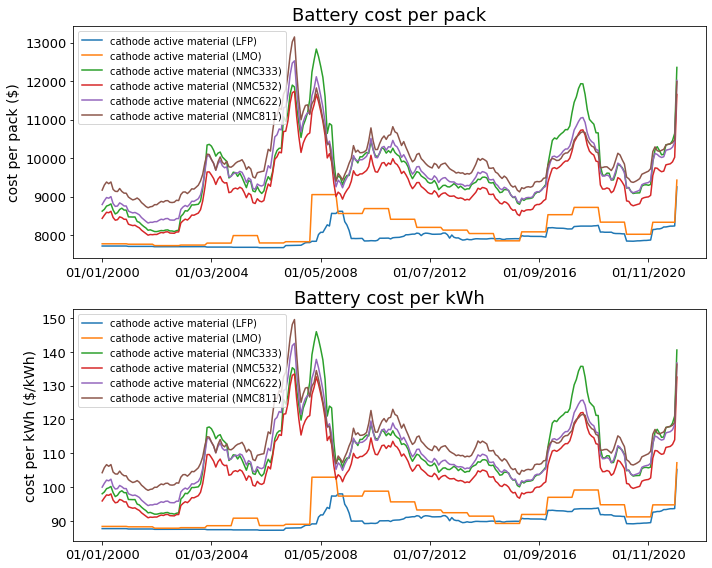

In [232]:
fig, ax = fig, ax = plt.subplots(2, 1, figsize=(10, 8))

historic_pack_cost.plot(ax=ax[0], fontsize=13)
(historic_pack_cost / result_dict["pack_energy_kWh"]).plot(ax=ax[1], fontsize=13)
ax[0].set_ylabel("cost per pack ($)", fontsize=14)
ax[1].set_ylabel("cost per kWh ($/kWh)", fontsize=14)
ax[0].set_xlabel("")
ax[1].set_xlabel("")
ax[0].set_title("Battery cost per pack", fontsize=18)
ax[1].set_title("Battery cost per kWh", fontsize=18)
fig.tight_layout()
